In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import random
import math

from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [3]:
N_EPOCH=5
ATTRS = True

In [4]:
import sys
sys.path.append("..")

from lib.Generators.AttributedNetwork import AttributedNetwork


generator = AttributedNetwork(
    '../data/',
    'citeseer',
    features_to_normalize=['RAI', 'JC', 'AAI', 'PA'],
    with_attributes=ATTRS,
    seed=seed,
    vebrose=True
)

feature_names = generator.t_feature_names

INFO: Verbose output.
INFO: Reading data ...
INFO: Success!
INFO: Train/test splitting the data...
INFO: Success!
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features


In [5]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

link_prediction_train.dropna(inplace=True)
link_prediction_test.dropna(inplace=True)
classifier_test.dropna(inplace=True)

In [6]:
link_prediction_train.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA
0,3284,4054,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000530
1,386,1285,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001060
2,1286,1972,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001060
3,131,2759,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.003976
4,570,4045,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000000


## Step 2
### Link prediction model

In [7]:
# set keras backend
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# import the model function
from lib.Keras.model import model

EMBED_DIM = 32

Using plaidml.keras.backend backend.


In [8]:
attr_dim = len(link_prediction_train.head(1)['node_1_attrs'].values[0]) if ATTRS else 1

link_prediction_model = model(feature_names, attr_dim, embed_dim=EMBED_DIM, attrs=ATTRS)
link_prediction_model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"
INFO: Opening device "metal_amd_radeon_pro_5300m.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Node 1 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
Node 2 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1204)         0           Node 1 attributes[0][0]          
                                                                 Node 2 attributes[0][0]          
__________________________________________________________________________________________________
Topological features input (Inp (None, 4)            0                                            
__________

DEBUG: Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


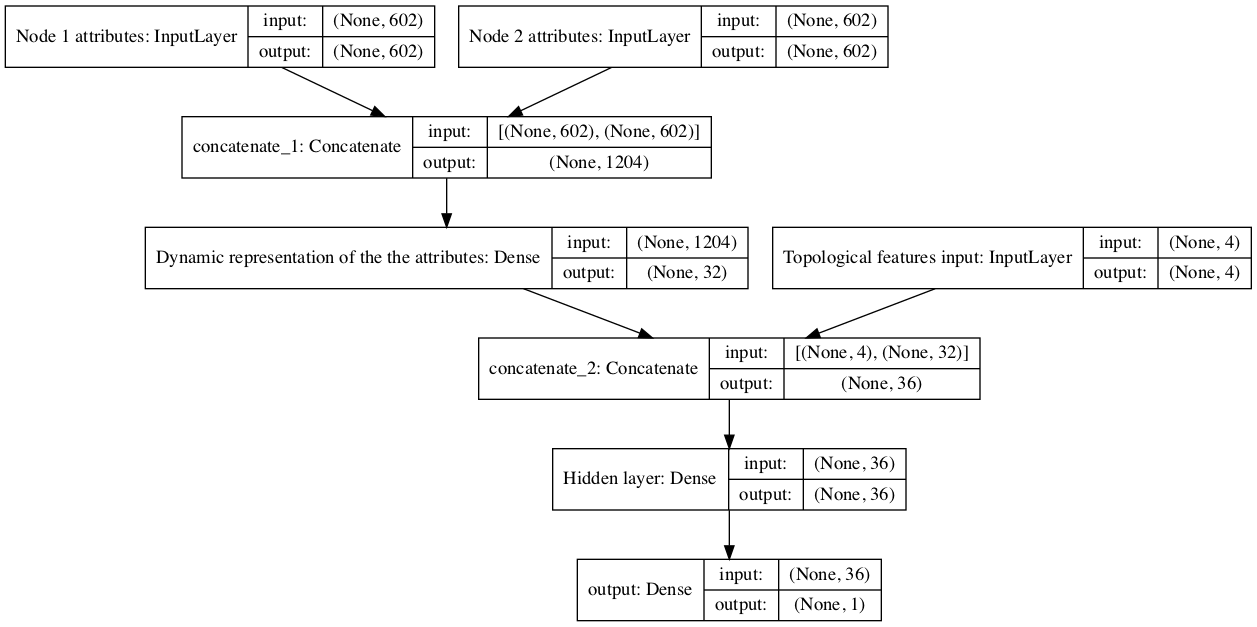

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(link_prediction_model, show_shapes=True)

In [10]:
from lib.data.data_arrange import data_arrange

x, y = data_arrange(link_prediction_train, feature_names, attrs=ATTRS)
link_prediction_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
7498/7498 [==============================] - 4s 532us/step - loss: 0.8121 - acc: 0.6921
Epoch 2/5
7498/7498 [==============================] - 1s 182us/step - loss: 0.7250 - acc: 0.7869
Epoch 3/5
7498/7498 [==============================] - 1s 152us/step - loss: 0.6720 - acc: 0.8484
Epoch 4/5
7498/7498 [==============================] - 1s 154us/step - loss: 0.6256 - acc: 0.8946
Epoch 5/5
7498/7498 [==============================] - 1s 146us/step - loss: 0.5836 - acc: 0.9361


DEBUG: matplotlib data path: /Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG: CONFIGDIR=/Users/andrejantonov/.matplotlib
DEBUG: matplotlib version 3.4.1
DEBUG: interactive is False
DEBUG: platform is darwin
DEBUG: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'functools', 'contextlib', 'importlib.util', 'g

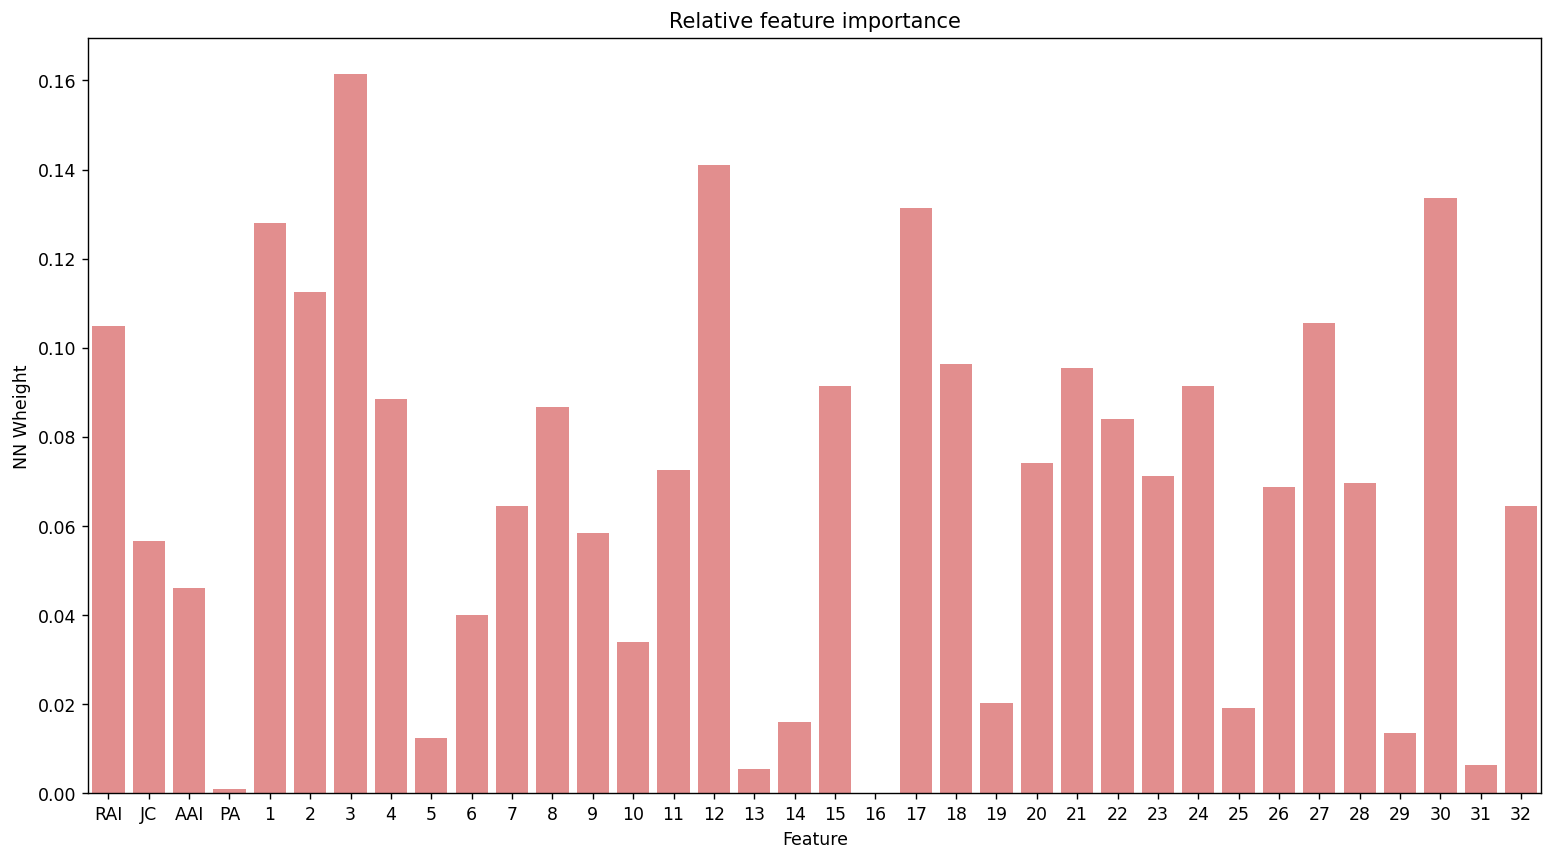

In [11]:
from lib.plotting.feature_importance import feature_importance

feature_importance(link_prediction_model, feature_names, embed_dim=EMBED_DIM, attrs=ATTRS)

In [12]:
# predicting the links

x, _ = data_arrange(link_prediction_test, feature_names, train=False, attrs=ATTRS)

prob = link_prediction_model.predict(x).squeeze()
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_test.join(prob)
link_proba.head(5)

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob
0,768,1623,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001572,0.004314
1,342,1558,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.010943
2,537,4180,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.017699
3,423,2559,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.002443
4,2683,3575,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000943,0.656914


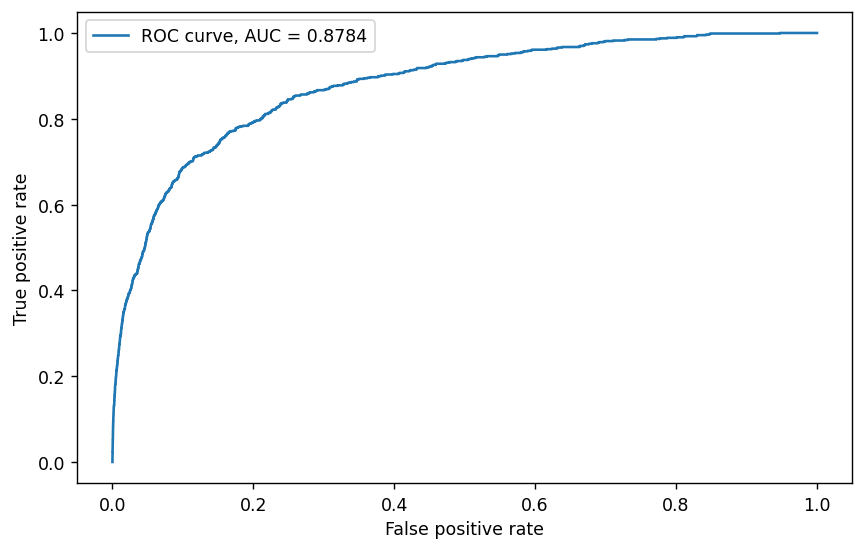

In [13]:
from lib.plotting.auc import plot_auc

# ROC-AUC for the link prediction model
plot_auc(link_proba, x='goal', y='prob')

## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [14]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob,abs_error
0,768,1623,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001572,0.004314,0.004314
1,342,1558,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.010943,0.010943
2,537,4180,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.017699,0.017699
3,423,2559,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.002443,0.002443
4,2683,3575,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000943,0.656914,0.656914


In [15]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.07591405138373375

In [16]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,prob,abs_error,quality_label
0,768,1623,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.001572,0.004314,0.004314,1
1,342,1558,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.010943,0.010943,1
2,537,4180,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.017699,0.017699,1
3,423,2559,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000314,0.002443,0.002443,1
4,2683,3575,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.000943,0.656914,0.656914,0


In [17]:
classification_model = model(feature_names, attr_dim, attrs=ATTRS)
classification_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Node 1 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
Node 2 attributes (InputLayer)  (None, 602)          0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1204)         0           Node 1 attributes[0][0]          
                                                                 Node 2 attributes[0][0]          
__________________________________________________________________________________________________
Topological features input (Inp (None, 4)            0                                            
__________

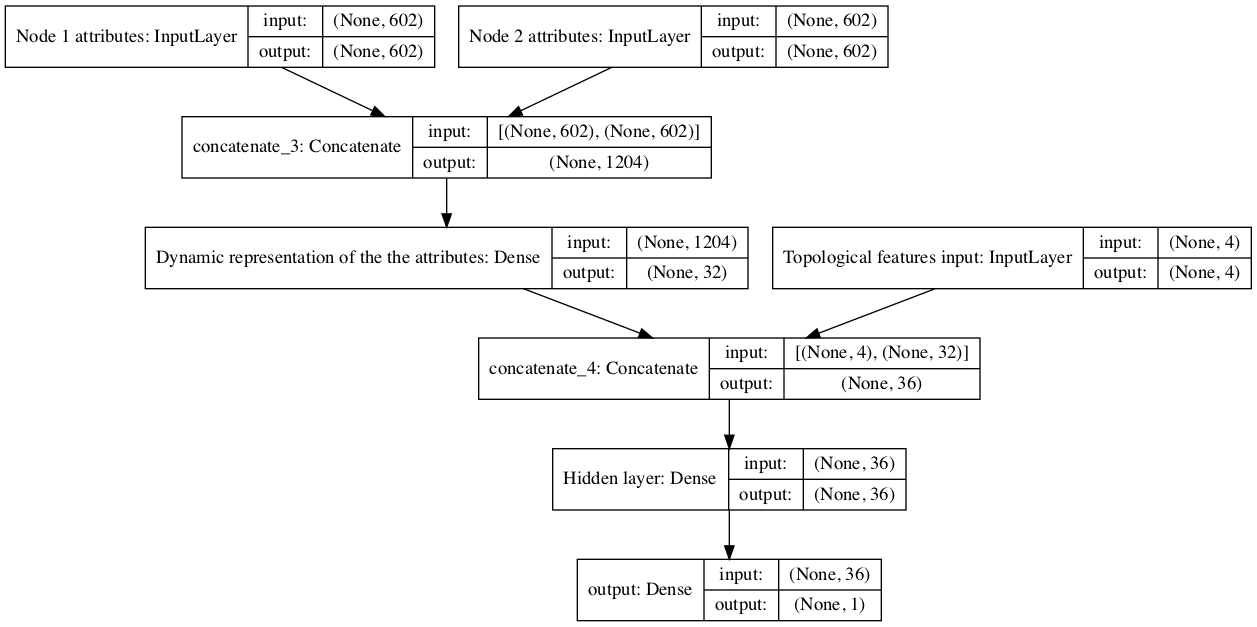

In [18]:
plot_model(classification_model, show_shapes=True)

In [19]:
x, y = data_arrange(link_proba, feature_names, goal='quality_label', attrs=ATTRS)
classification_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
1341650/1341650 [==============================] - 602s 449us/step - loss: 0.5910 - acc: 0.9214
Epoch 2/5
1341650/1341650 [==============================] - 462s 344us/step - loss: 0.5692 - acc: 0.9408
Epoch 3/5
1341650/1341650 [==============================] - 333s 248us/step - loss: 0.5637 - acc: 0.9455
Epoch 4/5
1341650/1341650 [==============================] - 335s 250us/step - loss: 0.5615 - acc: 0.9477
Epoch 5/5
1341650/1341650 [==============================] - 302s 225us/step - loss: 0.5604 - acc: 0.9485


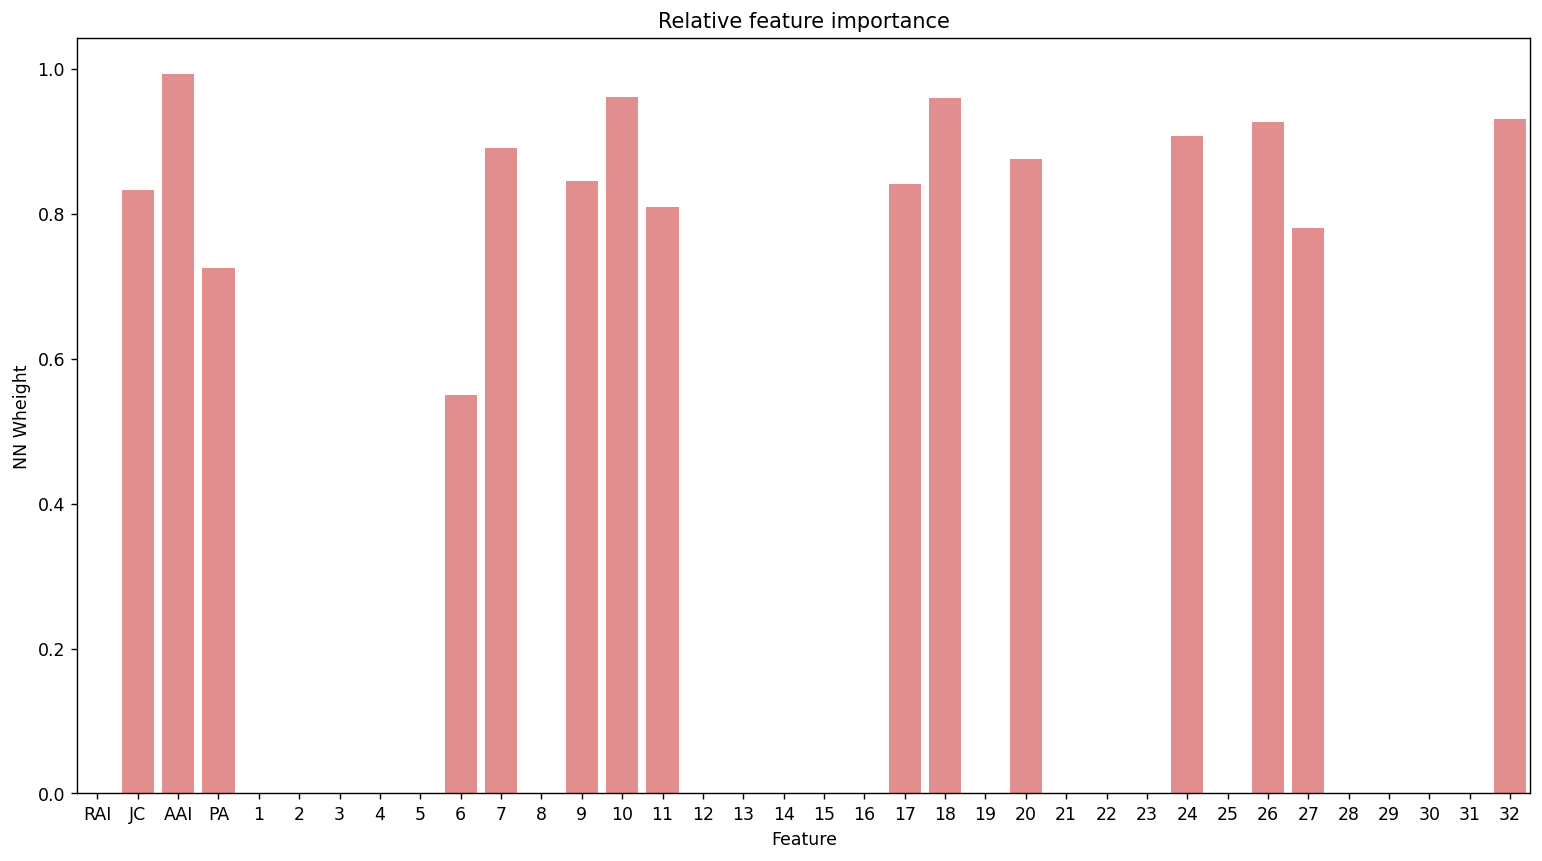

In [20]:
feature_importance(classification_model, feature_names, embed_dim=EMBED_DIM, attrs=ATTRS)

In [21]:
# testing the classifier

T = 0.5

x, _ = data_arrange(classifier_test, feature_names, train=False, attrs=ATTRS)

quality_probability = classification_model.predict(x).squeeze()
link_probability = link_prediction_model.predict(x).squeeze()

quality_label = [1 if i > T else 0 for i in quality_probability]

classifier_test = classifier_test.join(pd.Series(quality_probability, name='predicted_quality_prob'))
classifier_test = classifier_test.join(pd.Series(link_probability, name='predicted_link_probability'))
classifier_test = classifier_test.join(pd.Series(quality_label, name='predicted_quality_label'))

In [22]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['predicted_link_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.07555337995290756

In [23]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,node_1_attrs,node_2_attrs,RAI,JC,AAI,PA,predicted_quality_prob,predicted_link_probability,predicted_quality_label,true_abs_error,true_quality_label
0,0,3514,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000,0.000000,0.000300,0.000785,0.977204,0,0.022796,1
1,1,3089,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.035947,0.125,0.035197,0.005107,0.012519,0.991624,0,0.008376,1
2,1,3309,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000,0.000000,0.005107,0.001392,0.921468,0,0.078532,0
3,4,653,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000,0.000000,0.000901,0.011354,0.155485,0,0.844515,0
4,5,390,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000,0.000000,0.003004,0.000285,0.980593,0,0.019407,1


In [24]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     670833
0                     670818
dtype: int64

In [25]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
0                          681536
1                          660115
dtype: int64

In [26]:
from sklearn import metrics

classifier_test.dropna(inplace=True)
y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    metrics.precision_score(y_true, y_pred),
    metrics.recall_score(y_true, y_pred),
    metrics.f1_score(y_true, y_pred)
])

scores_df

,Metric,Score
0,Sample length,1.341651e+06
1,Precision,9.513539e-01
2,Recall,9.361540e-01
3,F1 score,9.436928e-01


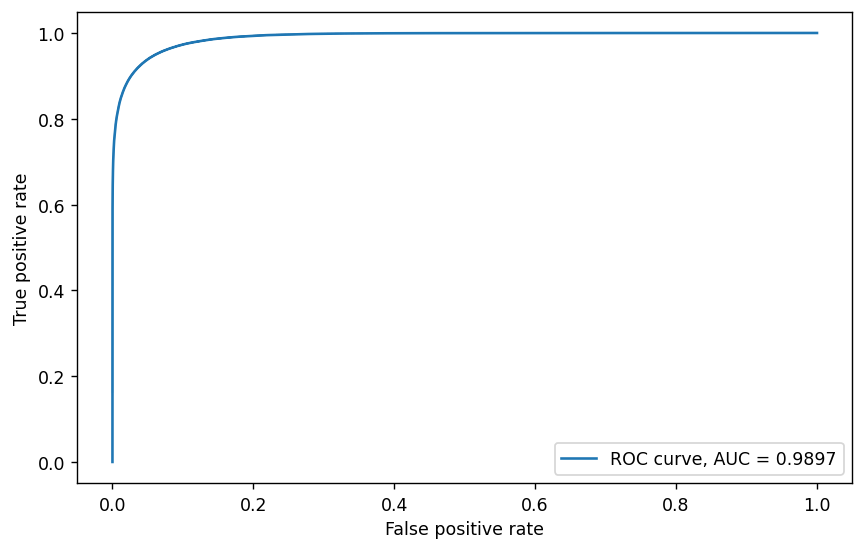

In [27]:
plot_auc(classifier_test, 'true_quality_label', 'predicted_quality_prob')